# Lightweight version of the End-to-End (E2E) model for movement encoding

Basically want to write the class for the network and some data loader functionality.

And end with a small training loop.

As a proof of concept we should provide training for a single session.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
def pile_array_lightweight(data, number_of_neighbors=5, offset=0):
    """
    Piles up neighboring frames into a single tensor.

    Args:
        data (torch.Tensor): Input tensor of shape (batch, seq_len, features).
        number_of_neighbors (int): Number of neighboring frames to include.
        offset (int): Offset for the first neighbor frame.

    Returns:
        torch.Tensor: Piled tensor of shape (batch, new_seq_len, features*number_of_neighbors).
    """
    batch_size, seq_len, n_features = data.shape
    new_seq_len = seq_len - number_of_neighbors + 1
    if new_seq_len <= 0:
        raise ValueError("Invalid sequence length after piling.")

    # Create an empty tensor for the piled output
    piled = torch.stack([data[:, i:i + new_seq_len] for i in range(number_of_neighbors)], dim=3)
    piled = piled.reshape(batch_size, new_seq_len, -1)
    if offset > 0:
        # Shift the piled tensor to account for the offset
        piled = torch.roll(piled, shifts=offset, dims=1)

    return piled

In [19]:
class ResidualBlock2D(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_preconv: int = 1,
                 kernel_residual: int = 3,
                 num_layers: int = 3,
                 use_batch_norm: bool = False):
        """
        A 2D residual block with optional channel projection.

        Args:
            in_channels (int):  Number of input channels.
            out_channels (int): Number of output channels.
            kernel_preconv (int): Kernel size for the initial projection conv.
            kernel_residual (int): Kernel size for the residual convs.
            num_layers (int): Number of conv layers in the residual path.
            use_batch_norm (bool): Whether to use BatchNorm2d after each conv.
        """
        super().__init__()
        self.use_batch_norm = use_batch_norm

        # Projection if channel dims change
        if in_channels != out_channels:
            proj_layers = [
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=kernel_preconv,
                          stride=1,
                          padding=(kernel_preconv - 1) // 2,
                          bias=not use_batch_norm)
            ]
            if use_batch_norm:
                proj_layers.append(nn.BatchNorm2d(out_channels))
            proj_layers.append(nn.ReLU(inplace=True))
            self.projection = nn.Sequential(*proj_layers)
        else:
            self.projection = None

        # Residual path
        res_layers = []
        for i in range(num_layers):
            res_layers.append(
                nn.Conv2d(out_channels, out_channels,
                          kernel_size=kernel_residual,
                          stride=1,
                          padding=(kernel_residual - 1) // 2,
                          bias=not use_batch_norm)
            )
            if use_batch_norm:
                res_layers.append(nn.BatchNorm2d(out_channels))
            if i < num_layers - 1:
                res_layers.append(nn.ReLU(inplace=True))
        self.residual = nn.Sequential(*res_layers)
        #self.post_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.projection is not None:
            proj = self.projection(x)
            res_in = proj
        else:
            proj = x
            res_in = x
        out = self.residual(res_in)
        out += proj
        return out


class Static2FrameEncoder(nn.Module):
    def __init__(self, configs: dict):
        """
        Args:
            configs (dict): Model configuration dictionary. Required keys:
                - in_channels (int)
                - cnn_channels (list of int)
                - kernel_preconv (int)
                - kernel_residual (int)
                - residual_depth (int)
                - pool_size (int)
                - use_batch_norm (bool)
                - neighbor_frames (int)
                - num_emit (int)
                - image_shape (tuple of int): (height, width)
        """
        super().__init__()
        self.configs = configs

        in_ch        = configs['in_channels']
        channels     = configs['cnn_channels']
        k_pre        = configs['kernel_preconv']
        k_res        = configs['kernel_residual']
        depth        = configs['residual_depth']
        pool_size    = configs['pool_size']
        use_bn       = configs['use_batch_norm']
        nbr_frames   = configs['neighbor_frames']
        num_emit     = configs['num_emit']
        img_h, img_w = configs['image_shape']

        # Build CNN feature extractor
        cnn_layers = []
        prev_ch = in_ch
        for out_ch in channels:
            # 1) the ResNet block (no external final ReLU here)
            cnn_layers.append(
                ResidualBlock2D(
                    in_channels=prev_ch,
                    out_channels=out_ch,
                    kernel_preconv=k_pre,
                    kernel_residual=k_res,
                    num_layers=depth,
                    use_batch_norm=use_bn
                )
            )
            # 2) then pool
            cnn_layers.append(nn.MaxPool2d(kernel_size=pool_size))
            # 3) then an explicit ReLU
            cnn_layers.append(nn.ReLU(inplace=True))
            prev_ch = out_ch
        self.cnn = nn.Sequential(*cnn_layers)

        # Compute flattened feature size after pooling and stacking
        total_down = pool_size ** len(channels)
        conv_h = img_h // total_down
        conv_w = img_w // total_down
        flat_size = conv_h * conv_w * channels[-1] * nbr_frames

        self.fc = nn.Linear(flat_size, num_emit)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Input of shape (batch, seq_len, C, H, W)
        Returns:
            torch.Tensor: Output of shape (batch, new_seq_len, num_emit)
        """
        bs, seq_len, C, H, W = x.shape
        # merge batch & seq dims for CNN
        x = x.view(bs * seq_len, C, H, W)
        x = self.cnn(x)
        # restore dims
        x = x.view(bs, seq_len, -1)
        # stack neighbor frames
        #print(x.shape)
        x = pile_array_lightweight(x, offset=0, number_of_neighbors=self.configs['neighbor_frames'])
        bs2, seq2, feat = x.shape
        #print(x.shape)
        x = x.view(bs2 * seq2, feat)
        #print(x.shape)
        # final linear layer
        x = self.fc(x)
        #print(x.shape)
        return x.view(bs, seq2, self.configs['num_emit'])







   



In [4]:
# Example standalone configuration dictionary
# config.py

configs = {
    # input & CNN architecture
    'in_channels'      : 1,             # matches first Conv2d(1,16)
    'cnn_channels'     : [16, 32, 32],  # matches your three ResNet out_chan values
    'kernel_preconv'   : 1,             # ks1=1 in conv0 projections
    'kernel_residual'  : 3,             # ks2=3 in residual convolutions
    'residual_depth'   : 3,             # res_depth=3 layers per ResNet block
    'pool_size'        : 4,             # each MaxPool2d(kernel_size=4)
    'use_batch_norm'   : True,          # your printed model shows BatchNorm2d

    # temporal stacking & final head
    'neighbor_frames'  : 5,    # FF-nbr → 32*5 = 160 features into the linear
    'num_emit'         : 143,  # FF-num_emit → Linear(out_features=143)

    # actual input spatial dimensions
    'image_shape'      : (120, 112),  # height, width
    }

In [5]:
model = Static2FrameEncoder(configs)

print(model)

Static2FrameEncoder(
  (cnn): Sequential(
    (0): ResidualBlock2D(
      (projection): Sequential(
        (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=4,

In [6]:
mock_input = torch.randn(16, 8, 1, 120, 112)  # (batch, seq_len, C, H, W)
output = model(mock_input)
print("Output shape:", output.shape)  # Expected: (batch, new_seq_len, num_emit)
# Example output shape: (2, 10, 143) if seq_len is preserved

torch.Size([16, 8, 32])
torch.Size([16, 4, 160])
torch.Size([64, 160])
torch.Size([64, 143])
Output shape: torch.Size([16, 4, 143])


Now I need:
- example data for frames and firing rates
- figure out the cost function and optimizer and their parameters, and hyperparams
- write a data loader or see if I can use the one I had for the autoencoder
- provide a small example training looop

In [6]:
import webdataset as wds
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
import time
import pickle

import tarfile
from io import BytesIO
from PIL import Image

In [7]:
class CustomCropResize:
    def __init__(self, target_shape=(120, 112, 1), crop_info={'h_coord': 26}):
        """
        Args:
            target_shape: (height, width, channels)
            crop_info: dict with cropping parameters. For example, 
                       crop_info['h_coord'] determines the crop start as:
                       int(crop_info['h_coord'] / target_height * original_height + 0.5)
        """
        self.target_shape = target_shape
        self.crop_info = crop_info

    def __call__(self, img):
        # Ensure the image is in grayscale
        if img.mode != 'L':
            img = img.convert('L')
        # Get target height and width from target_shape
        h_target, w_target, _ = self.target_shape
        # Get original dimensions (PIL gives (width, height))
        original_width, original_height = img.size
        # Compute the vertical crop coordinate, analogous to your cv2 code
        crop_y = int(self.crop_info['h_coord'] / h_target * original_height + 0.5)
        # Crop the image: from crop_y to bottom, full width
        img = F.crop(img, crop_y, 0, original_height - crop_y, original_width)
        # Resize the image to the target dimensions.
        # F.resize expects size as (height, width).
        img = F.resize(img, (h_target, w_target))
        # Convert the image to a tensor (this scales pixel values to [0, 1])
        img = F.to_tensor(img)
        return img
    
custom_transform = CustomCropResize(target_shape=(120, 112, 1), crop_info={'h_coord': 26})


In [8]:
# Create an instance of your custom transform
custom_transform = CustomCropResize(target_shape=(120, 112, 1), crop_info={'h_coord': 26})

dataset = wds.WebDataset(
    "/home/kurgyis/Research/MapVideoAnalysis/data/raw_frames/SC065_20210506_frames.tar"
).select(lambda sample: "jpg" in sample) \
  .shuffle(1000).decode('pil') \
  .to_tuple("jpg") \
  .map(lambda x: custom_transform(x[0]))

dataloader = DataLoader(dataset, batch_size=64, num_workers=1)

# Iterate over batches for example timing

start_time = time.time()
for i, batch in enumerate(dataloader):
    if i >= 100:
        break
end_time = time.time()
print(f"Images per second: {64 / ((end_time - start_time) / 100):.2f}")
images_per_second = 64 / ((end_time - start_time) / 100)
estimated_total_time = (700000 / images_per_second) / 60  # Minutes
print(f"Estimated time to load 700k images: {estimated_total_time:.2f} minutes")

/home/kurgyis/Research/MapVideoAnalysis/local_venv/lib/python3.12/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(


Images per second: 2392.78
Estimated time to load 700k images: 4.88 minutes


In [10]:
batch.shape

torch.Size([64, 1, 120, 112])

The problem with this dataloader is that it is not able to extract sequences of frames from the same trial, which is needed for the E2E model. I will likely have to turn to a different solution for data loading.

In [9]:
#go_times = mat_data['task_cue_time'][0]
dt = 0.0034 # sampling interval in seconds

def get_frames_between_limits(frame_inds, go_time, start_time = -2, end_time = 1.2, dt=0.0034):
    frame_times = frame_inds * dt - go_time
    frame_mask = (frame_times >= start_time) * (frame_times <= end_time)
    return frame_inds[frame_mask]  # Return the indices of frames within the limits

In [10]:
ephys_filename = '../../data/ephys_for_e2e/1_right_ALM.pickle'

def load_ephys_data(filename):
    with open(filename, 'rb') as f:
        ephys_data = pickle.load(f)
    return ephys_data
ephys_data = load_ephys_data(ephys_filename)

ephys_data.keys()  # Check the keys in the loaded ephys data

dict_keys(['sess_name', 'area', 'bin_centers', 'fr', 'spike_times', 'neuron_info', 'unit_qc', 'ccf_coordinate', 'ccf_label', 'ccf_unit_id', 'auto_learn_trials', 'early_lick_trials', 'auto_water_trials', 'free_water_trials', 'lick_directions', 'lick_times', 'gocue_time', 'correctness', 'delay_period', 'sample_period', 'stimulation', 'trial_type'])

In [11]:
FR = ephys_data['fr']
tt = ephys_data['bin_centers']


time_mask = (tt >= -2) & (tt <= 1.2)
FR = FR[time_mask]

In [12]:
frame_folder = '/home/kurgyis/Research/MapVideoAnalysis/data/raw_frames/SC065_20210506_split_frames/'

trials = os.listdir(frame_folder)
trials

['SC-SC065-20210506-32',
 'SC-SC065-20210506-306',
 'SC-SC065-20210506-33',
 'SC-SC065-20210506-225',
 'SC-SC065-20210506-147',
 'SC-SC065-20210506-312',
 'SC-SC065-20210506-156',
 'SC-SC065-20210506-23',
 'SC-SC065-20210506-293',
 'SC-SC065-20210506-411',
 'SC-SC065-20210506-188',
 'SC-SC065-20210506-158',
 'SC-SC065-20210506-490',
 'SC-SC065-20210506-237',
 'SC-SC065-20210506-257',
 'SC-SC065-20210506-368',
 'SC-SC065-20210506-280',
 'SC-SC065-20210506-229',
 'SC-SC065-20210506-404',
 'SC-SC065-20210506-105',
 'SC-SC065-20210506-430',
 'SC-SC065-20210506-88',
 'SC-SC065-20210506-521',
 'SC-SC065-20210506-325',
 'SC-SC065-20210506-479',
 'SC-SC065-20210506-301',
 'SC-SC065-20210506-83',
 'SC-SC065-20210506-359',
 'SC-SC065-20210506-68',
 'SC-SC065-20210506-36',
 'SC-SC065-20210506-455',
 'SC-SC065-20210506-324',
 'SC-SC065-20210506-465',
 'SC-SC065-20210506-35',
 'SC-SC065-20210506-112',
 'SC-SC065-20210506-172',
 'SC-SC065-20210506-161',
 'SC-SC065-20210506-281',
 'SC-SC065-20210506-

In [60]:
def get_frames_between_limits(frame_inds, go_time, start_time = -2, end_time = 1.2, dt=0.0034):
    frame_times = frame_inds * dt - go_time
    starting_ind = np.where(frame_times <= start_time)[0][-1]
    ending_ind = starting_ind + int((end_time - start_time) / dt)
    frame_mask = (frame_inds >= starting_ind) * (frame_inds < ending_ind)
    return frame_inds[frame_mask]  # Return the indices of frames within the limits

def read_frame_from_folder(folder_name, frame_name):

    frame_path = os.path.join(folder_name, frame_name)
    img = Image.open(frame_path)
    img = custom_transform(img)  # Apply the custom transform
    return img

def load_frames_from_inds(folder_name, frame_inds):
    frames = sorted([s for s in os.listdir(folder_name) if s.endswith('.jpg') and int(s.split('-')[-1].split('.')[0]) in frame_inds])
    jpg_data = []
    for frame_name in frames:
        img = read_frame_from_folder(folder_name, frame_name)
        jpg_data.append(img)
    jpg_data = torch.stack(jpg_data, dim=0)  # Stack into a tensor
    return jpg_data

dataset_configs = {
    'start_time': 0,
    'end_time': 1.,
    'dt': 0.0034,
    'sequence_length': 64,
    'frame_array_passed': False,
    'center_fr': True,
    'center_frames': False,
}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, frame_folder, ephys_data, trials, go_times, start_time = 0, end_time = 1., dt=0.0034, sequence_length = 64, frame_array_passed=False, center_fr=True, center_frames=False):

        self.frame_folder = frame_folder
        self.ephys_data = ephys_data
        self.go_times = go_times
        self.start_time = start_time
        self.end_time = end_time
        self.dt = dt
        self.sequence_length = sequence_length
        self.frame_array_passed = frame_array_passed
        self.center_fr = center_fr
        self.center_frames = center_frames
        if frame_array_passed:
            self.frames = frame_folder
            good_trial_mask = np.ones(len(trials), dtype=bool)  # All trials are considered good
        else:
            good_trial_mask = self.check_trials_intact(trials, go_times)
        self.trials = np.array(trials)[good_trial_mask]
        self.tt_ephys = ephys_data['bin_centers']
        self.FR_ephys = ephys_data['fr']
        time_mask = (self.tt_ephys >= self.start_time) & (self.tt_ephys <= self.end_time)
        self.this_tt = self.tt_ephys[time_mask]
        self.n_sequences = len(self.this_tt) // self.sequence_length
        print(self.start_time, self.end_time, self.dt, self.n_sequences)
        self.get_fr_mean_and_std()

    def __len__(self):
        return self.n_sequences * len(self.trials)

    def check_single_trial_intact(self, trial_name, go_time):
        """Check if a single trial has all the frames intact."""
        
        frames = sorted([s for s in os.listdir(os.path.join(self.frame_folder, trial_name)) if s.endswith('.jpg')])
        frame_inds = np.array([int(f.split('-')[-1].split('.')[0]) for f in frames])
        frames_within_lims = get_frames_between_limits(frame_inds, go_time, start_time=self.start_time, end_time=self.end_time, dt=self.dt)
        expected_number_of_frames = int((self.end_time - self.start_time) / self.dt)
        
        if len(frames_within_lims) != expected_number_of_frames:
            print(f"Warning: Trial {trial_name} has {len(frames_within_lims)} frames, expected {expected_number_of_frames}.")
            return False
        if len(frames_within_lims) == 0:
            print(f"Warning: No frames found for trial {trial_name} within limits.")
            return False
        return True

    def check_trials_intact(self, trials, go_times):
        """Check if trials have all the frames intact."""
        trial_order = [int(trial_name.split('-')[-1])-1 for trial_name in trials]
        good_trial_mask = np.array([self.check_single_trial_intact(trial_name, go_time) for trial_name, go_time in zip(trials, go_times[trial_order])])
        return good_trial_mask
    
    def get_fr_mean_and_std(self):
        time_mask = (self.tt_ephys >= self.start_time) & (self.tt_ephys <= self.end_time)
        FR_bounds = self.FR_ephys[time_mask]
        fr_mean = FR_bounds.mean(axis=(0,1))
        fr_std = FR_bounds.std(axis=(0,1)) + np.finfo(float).eps  # Add small value to avoid division by zero
        self.fr_mean = fr_mean
        self.fr_std = fr_std
        return fr_mean, fr_std
    
    def get_frames_mean_and_std(self):
        if self.frame_array_passed:
            self.frame_mean = 1
            self.frame_std = 1
            return 1, 1
        else:
            frame_mean = self.frames.mean(axis = (0,1), keepdims=True)
            frame_std = self.frames.std(axis = (0,1), keepdims=True) + np.finfo(float).eps
            self.frame_mean = frame_mean
            self.frame_std = frame_std
            return frame_mean, frame_std

    def __getitem__(self, idx):
        trial_ii = idx // self.n_sequences
        sequence_ii = idx % self.n_sequences

        trial_name = self.trials[trial_ii]
        trial_idx = int(trial_name.split('-')[-1])
        if self.frame_array_passed:
            jpg_data = self.frames[trial_ii]
        else:
            frames = sorted([s for s in os.listdir(os.path.join(self.frame_folder, trial_name)) if s.endswith('.jpg')])
            frame_inds = np.array([int(f.split('-')[-1].split('.')[0]) for f in frames])
            frames_within_lims = get_frames_between_limits(frame_inds, self.go_times[trial_idx-1], start_time=self.start_time, end_time=self.end_time, dt=self.dt)
            jpg_data = load_frames_from_inds(os.path.join(self.frame_folder, trial_name), frames_within_lims)

        time_mask = (self.tt_ephys >= self.start_time) & (self.tt_ephys <= self.end_time)
        self.this_tt = self.tt_ephys[time_mask]
        this_FR = self.FR_ephys[time_mask][:,trial_idx]

        sequence_ids = np.arange(sequence_ii * self.sequence_length, (sequence_ii + 1) * self.sequence_length)
        this_FR = this_FR[sequence_ids]
        jpg_data = jpg_data[sequence_ids]

        if self.center_fr:
            this_FR = (this_FR - self.fr_mean) / self.fr_std
        if self.center_frames:
            jpg_data = (jpg_data - self.frame_mean) / self.frame_std
            
        return jpg_data, this_FR, trial_idx

In [61]:
trials

['SC-SC065-20210506-32',
 'SC-SC065-20210506-306',
 'SC-SC065-20210506-33',
 'SC-SC065-20210506-225',
 'SC-SC065-20210506-147',
 'SC-SC065-20210506-312',
 'SC-SC065-20210506-156',
 'SC-SC065-20210506-23',
 'SC-SC065-20210506-293',
 'SC-SC065-20210506-411',
 'SC-SC065-20210506-188',
 'SC-SC065-20210506-158',
 'SC-SC065-20210506-490',
 'SC-SC065-20210506-237',
 'SC-SC065-20210506-257',
 'SC-SC065-20210506-368',
 'SC-SC065-20210506-280',
 'SC-SC065-20210506-229',
 'SC-SC065-20210506-404',
 'SC-SC065-20210506-105',
 'SC-SC065-20210506-430',
 'SC-SC065-20210506-88',
 'SC-SC065-20210506-521',
 'SC-SC065-20210506-325',
 'SC-SC065-20210506-479',
 'SC-SC065-20210506-301',
 'SC-SC065-20210506-83',
 'SC-SC065-20210506-359',
 'SC-SC065-20210506-68',
 'SC-SC065-20210506-36',
 'SC-SC065-20210506-455',
 'SC-SC065-20210506-324',
 'SC-SC065-20210506-465',
 'SC-SC065-20210506-35',
 'SC-SC065-20210506-112',
 'SC-SC065-20210506-172',
 'SC-SC065-20210506-161',
 'SC-SC065-20210506-281',
 'SC-SC065-20210506-

In [62]:
frame_dataset = CustomDataset(frame_folder, ephys_data, trials, ephys_data['gocue_time'], start_time=0., end_time=1, dt=dt, sequence_length = 256, center_fr = False, center_frames = False)

frame_dataloader = DataLoader(frame_dataset, batch_size=16, num_workers=1)

# Iterate over batches for example timing
start_time = time.time()
for i, (batch, batch_fr, trial_idx) in enumerate(frame_dataloader):
    if i >= 5:
        break
end_time = time.time()
print(f"Images per second: {16 * 5 * (3.2/dt) / (end_time - start_time):.2f}")

0.0 1 0.0034 1
Images per second: 4272.84


In [63]:
batch.shape, batch_fr.shape, trial_idx.shape

(torch.Size([16, 256, 1, 120, 112]),
 torch.Size([16, 256, 73]),
 torch.Size([16]))

In [64]:
trial_idx

tensor([134,  75, 486, 351, 444, 433, 457, 469,  89, 240, 347, 346, 439,  84,
        278,  14])

Need to do:
- center the firing rates and the frames bsed on mean and std
- do I do this for the whole training set? and if so what do I do about the test set?
- the loss seems to be simply mse for the centered firing rates
- what is the optimizer and what are the hyperparameters?

- need to doublecheck the architecture and that it matches Aiden's model

- would be best to obtain a config file, but seems like I cant connect to CCN from VScode


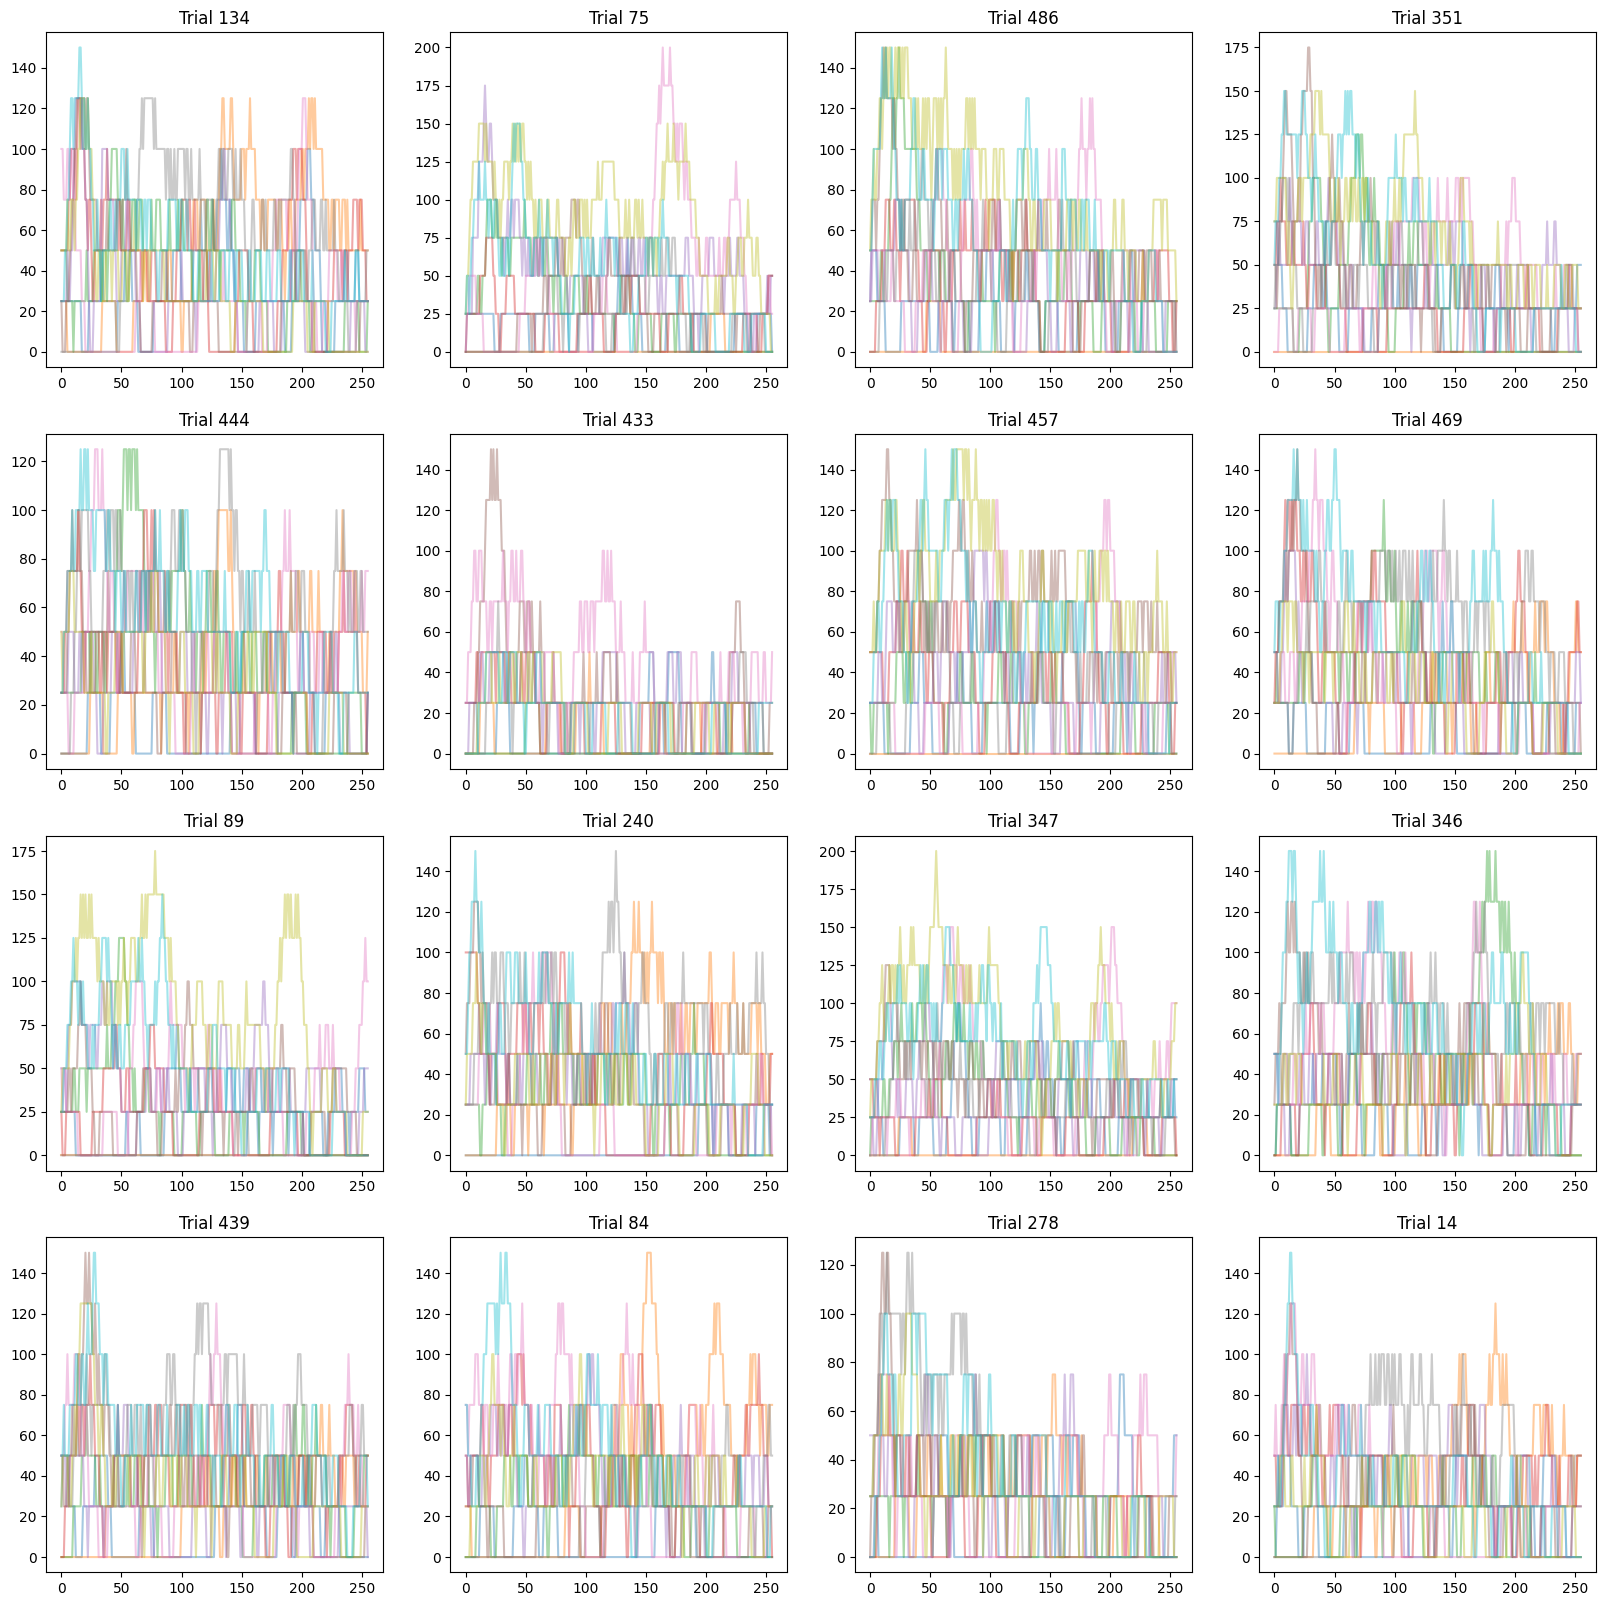

In [65]:
plt.figure(figsize=(20, 20))
top_fr_inds = np.argsort(batch_fr.mean(axis=(0,1)))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(batch_fr[i,:,top_fr_inds[-10:]].cpu().numpy(),alpha = 0.4)
    plt.title(f"Trial {trial_idx[i]}")

In [66]:
batch_fr[:,:,top_fr_inds[-10:]]

tensor([[[25., 25., 50.,  ...,  0., 50., 25.],
         [25., 25., 50.,  ...,  0., 50., 25.],
         [25., 25., 50.,  ...,  0., 50., 25.],
         ...,
         [25., 50.,  0.,  ..., 25.,  0., 25.],
         [25., 50.,  0.,  ..., 50.,  0., 25.],
         [25., 50., 25.,  ..., 50.,  0., 25.]],

        [[25.,  0., 25.,  ...,  0., 25., 25.],
         [25.,  0., 25.,  ...,  0., 50., 50.],
         [25.,  0., 25.,  ...,  0., 50., 50.],
         ...,
         [25.,  0.,  0.,  ...,  0., 25.,  0.],
         [25.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[25.,  0., 25.,  ...,  0., 50., 50.],
         [50.,  0., 25.,  ...,  0., 75., 50.],
         [50.,  0., 25.,  ...,  0., 75., 75.],
         ...,
         [ 0.,  0., 25.,  ..., 25., 50.,  0.],
         [ 0.,  0., 25.,  ..., 25., 50.,  0.],
         [ 0.,  0., 25.,  ...,  0., 25.,  0.]],

        ...,

        [[ 0., 25.,  0.,  ...,  0.,  0., 75.],
         [ 0., 25.,  0.,  ...,  0.,  0., 75.]

In [67]:
batch_fr.shape

torch.Size([16, 256, 73])

In [20]:
time_mask = (frame_dataset.ephys_data['bin_centers'] >= 0) & (frame_dataset.ephys_data['bin_centers'] <= 1.)
times = frame_dataset.ephys_data['bin_centers'][time_mask]

In [51]:
example_trials = ['example_trial-%i' % (i+1) for i in range(16)]

In [52]:
example_data = {
    'frames': batch,
    'fr': batch_fr[:,:,top_fr_inds[-10:]],
    'trial_idx': trial_idx,
    'trials': example_trials,
    'tt': times,
    'go_times': ephys_data['gocue_time'][trial_idx-1],
    'start_time':frame_dataset.start_time,
    'end_time': frame_dataset.end_time,
    'dt': frame_dataset.dt,
}

import pickle

with open('../../data/example_e2e_data_response.pickle', 'wb') as f:
    pickle.dump(example_data, f)

In [68]:
new_frame_dataset = CustomDataset(example_data['frames'], 
                                  {'fr': example_data['fr'].roll(1), 'bin_centers': example_data['tt']}, 
                                  example_data['trials'], 
                                  example_data['go_times'], 
                                  start_time=0., end_time=0.6, 
                                  dt=dt, sequence_length = 64, 
                                  frame_array_passed=True, 
                                  center_fr = True, 
                                  center_frames = True)

0.0 0.6 0.0034 2


IndexError: The shape of the mask [294] at index 0 does not match the shape of the indexed tensor [16, 256, 10] at index 0

## Work with the saved mini dataset

In [8]:
import pickle

In [9]:
with open('../../data/example_e2e_data_response.pickle', 'rb') as f:
    loaded_example_data = pickle.load(f)
print("Loaded example data:", loaded_example_data.keys())

Loaded example data: dict_keys(['frames', 'fr', 'trial_idx', 'trials', 'tt', 'go_times', 'start_time', 'end_time', 'dt'])


In [10]:
loaded_example_data['frames'].shape, loaded_example_data['fr'].shape, loaded_example_data['trial_idx'].shape

(torch.Size([16, 256, 1, 120, 112]),
 torch.Size([16, 256, 10]),
 torch.Size([16]))

In [70]:
class MiniFrameDataset(torch.utils.data.Dataset):
    def __init__(self, loaded_example_data, sequence_length=16, center_fr=True, center_frames=True):
        """
        Args:
            loaded_example_data (dict): Dictionary containing the example data.
            sequence_length (int): Length of each sequence.
            center_fr (bool): Whether to center the firing rates.
            center_frames (bool): Whether to center the frames.
        """
        self.frames = loaded_example_data['frames'] # shape: trial, timepoint, channel(1), height(120), width(112)
        self.FR_ephys = loaded_example_data['fr'] # shape: trial, timepoint, neurons(10)
        self.trials = loaded_example_data['trials']
        self.go_times = loaded_example_data['go_times']
        self.tt_ephys = loaded_example_data['tt']
        self.start_time = loaded_example_data['start_time']
        self.end_time = loaded_example_data['end_time']
        self.dt = loaded_example_data['dt']
        self.sequence_length = sequence_length
        self.center_fr = center_fr
        self.center_frames = center_frames
        self.n_sequences =  self.frames.shape[1] // self.sequence_length

        if self.center_fr:
            self.fr_mean, self.fr_std = self._get_mean_and_std(self.FR_ephys)
        else:
            self.fr_mean = 1.
            self.fr_std = 1.
        if self.center_frames:
            self.frame_mean, self.frame_std = self._get_mean_and_std(self.frames)
        else:
            self.frame_mean = 1.
            self.frame_std = 1.


    def __len__(self):
        return self.frames.shape[0] * self.n_sequences

    def _get_mean_and_std(self, array_3d):
        """Calculate mean and std for a 3D array."""
        mean = array_3d.mean(axis=(0, 1))
        std = array_3d.std(axis=(0, 1)) + np.finfo(float).eps
        return mean, std

    def __getitem__(self, idx):
        trial_ii = idx // self.n_sequences
        sequence_ii = idx % self.n_sequences

        fr_data = self.FR_ephys[trial_ii, sequence_ii * self.sequence_length:(sequence_ii + 1) * self.sequence_length]
        jpg_data = self.frames[trial_ii, sequence_ii * self.sequence_length:(sequence_ii + 1) * self.sequence_length]

        fr_data = (fr_data - self.fr_mean[None,:]) / self.fr_std[None,:]
        jpg_data = (jpg_data - self.frame_mean[None,...]) / self.frame_std[None,...]
            
        return jpg_data, fr_data, trial_ii, sequence_ii

In [115]:
mini_dataset = MiniFrameDataset(loaded_example_data, sequence_length=128, center_fr=True, center_frames=True)
mini_dataloader = DataLoader(mini_dataset, batch_size=4, num_workers=1, shuffle=True)

In [116]:
mini_configs = {
    # input & CNN architecture
    'in_channels'      : 1,             # matches first Conv2d(1,16)
    'cnn_channels'     : [16, 32, 32],  # matches your three ResNet out_chan values
    'kernel_preconv'   : 1,             # ks1=1 in conv0 projections
    'kernel_residual'  : 3,             # ks2=3 in residual convolutions
    'residual_depth'   : 3,             # res_depth=3 layers per ResNet block
    'pool_size'        : 4,             # each MaxPool2d(kernel_size=4)
    'use_batch_norm'   : True,          # your printed model shows BatchNorm2d

    # temporal stacking & final head
    'neighbor_frames'  : 5,    # FF-nbr → 32*5 = 160 features into the linear
    'num_emit'         : 10,  # FF-num_emit → Linear(out_features=143)

    # actual input spatial dimensions
    'image_shape'      : (120, 112),  # height, width
    }

In [117]:
model = Static2FrameEncoder(mini_configs)

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Static2FrameEncoder(
  (cnn): Sequential(
    (0): ResidualBlock2D(
      (projection): Sequential(
        (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=4,

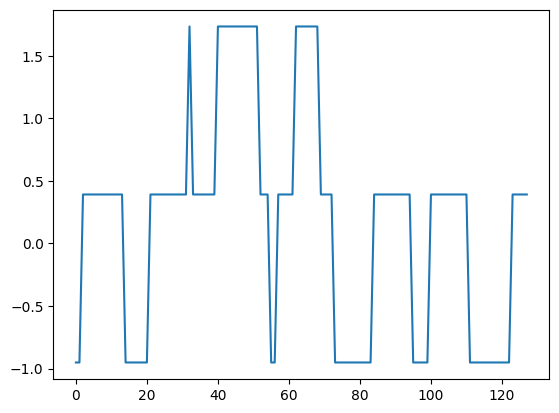

In [119]:
plt.plot(batch_fr[0,:,0].cpu().numpy(), label='Original FR')

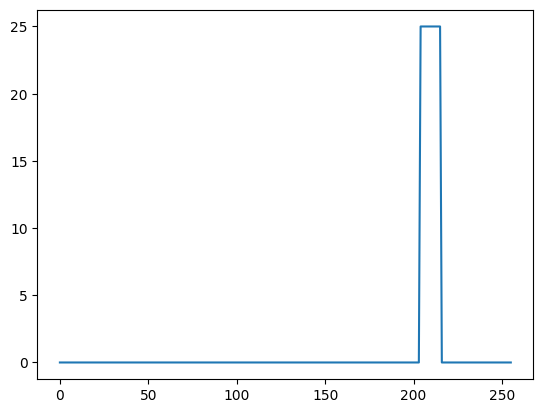

In [120]:
plt.plot(loaded_example_data['fr'][1,:,1])

In [121]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loss = []
# Training loop
for epoch in range(200):  # Example: 5 epochs
    model.train()
    for i, (batch, batch_fr, trial_idx, sequence_idx) in enumerate(mini_dataloader):
        optimizer.zero_grad()
        output = model(batch.to(device))
        loss = torch.mean((output- batch_fr[:,2:-2].to(device))**2)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch} completed.")
    print(f"Final loss after epoch {epoch}: {loss.item():.4f}")



Epoch 0, Batch 0, Loss: 7.9320
Epoch 0 completed.
Final loss after epoch 0: 1.5884
Epoch 1, Batch 0, Loss: 1.3371
Epoch 1 completed.
Final loss after epoch 1: 1.2971
Epoch 2, Batch 0, Loss: 1.2894
Epoch 2 completed.
Final loss after epoch 2: 0.9711
Epoch 3, Batch 0, Loss: 1.0862
Epoch 3 completed.
Final loss after epoch 3: 0.9929
Epoch 4, Batch 0, Loss: 1.0722
Epoch 4 completed.
Final loss after epoch 4: 0.7431
Epoch 5, Batch 0, Loss: 1.0303
Epoch 5 completed.
Final loss after epoch 5: 0.9201
Epoch 6, Batch 0, Loss: 0.8771
Epoch 6 completed.
Final loss after epoch 6: 0.9357
Epoch 7, Batch 0, Loss: 0.7878
Epoch 7 completed.
Final loss after epoch 7: 0.8490
Epoch 8, Batch 0, Loss: 0.7233
Epoch 8 completed.
Final loss after epoch 8: 0.8537
Epoch 9, Batch 0, Loss: 0.6920
Epoch 9 completed.
Final loss after epoch 9: 0.8081
Epoch 10, Batch 0, Loss: 0.6515
Epoch 10 completed.
Final loss after epoch 10: 0.6551
Epoch 11, Batch 0, Loss: 0.7162
Epoch 11 completed.
Final loss after epoch 11: 0.927

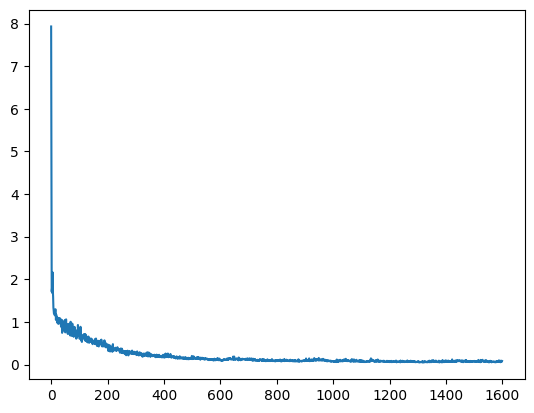

In [122]:
plt.plot(train_loss)

In [123]:
batch_fr.shape

torch.Size([4, 128, 10])

In [124]:
full_fr_data = np.zeros((16,256-4*256//mini_dataset.sequence_length,10))
full_output = np.zeros((16,256-4*256//mini_dataset.sequence_length,10))
trial_ids = []
sequence_ids = []

eff_seq_len = mini_dataset.sequence_length - 4

with torch.no_grad():
    for batch, batch_fr, trial_idx, sequence_idx in mini_dataloader:
        output = model(batch.to(device))
        for ii,s_ii in enumerate(sequence_idx):
            full_fr_data[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = batch_fr[ii,2:-2].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_mean[None,:]
            full_output[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = output[ii].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_std[None,:]
        trial_ids.append(trial_idx.cpu())
        sequence_ids.append(sequence_idx.cpu())


/tmp/ipykernel_1326/2529484404.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  full_fr_data[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = batch_fr[ii,2:-2].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_mean[None,:]
/tmp/ipykernel_1326/2529484404.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  full_output[trial_idx[ii], s_ii*eff_seq_len:(s_ii+1)*eff_seq_len] = output[ii].cpu()*mini_dataset.fr_std[None,:] + mini_dataset.fr_std[None,:]


In [125]:
sequence_idx

tensor([0, 0, 1, 1])

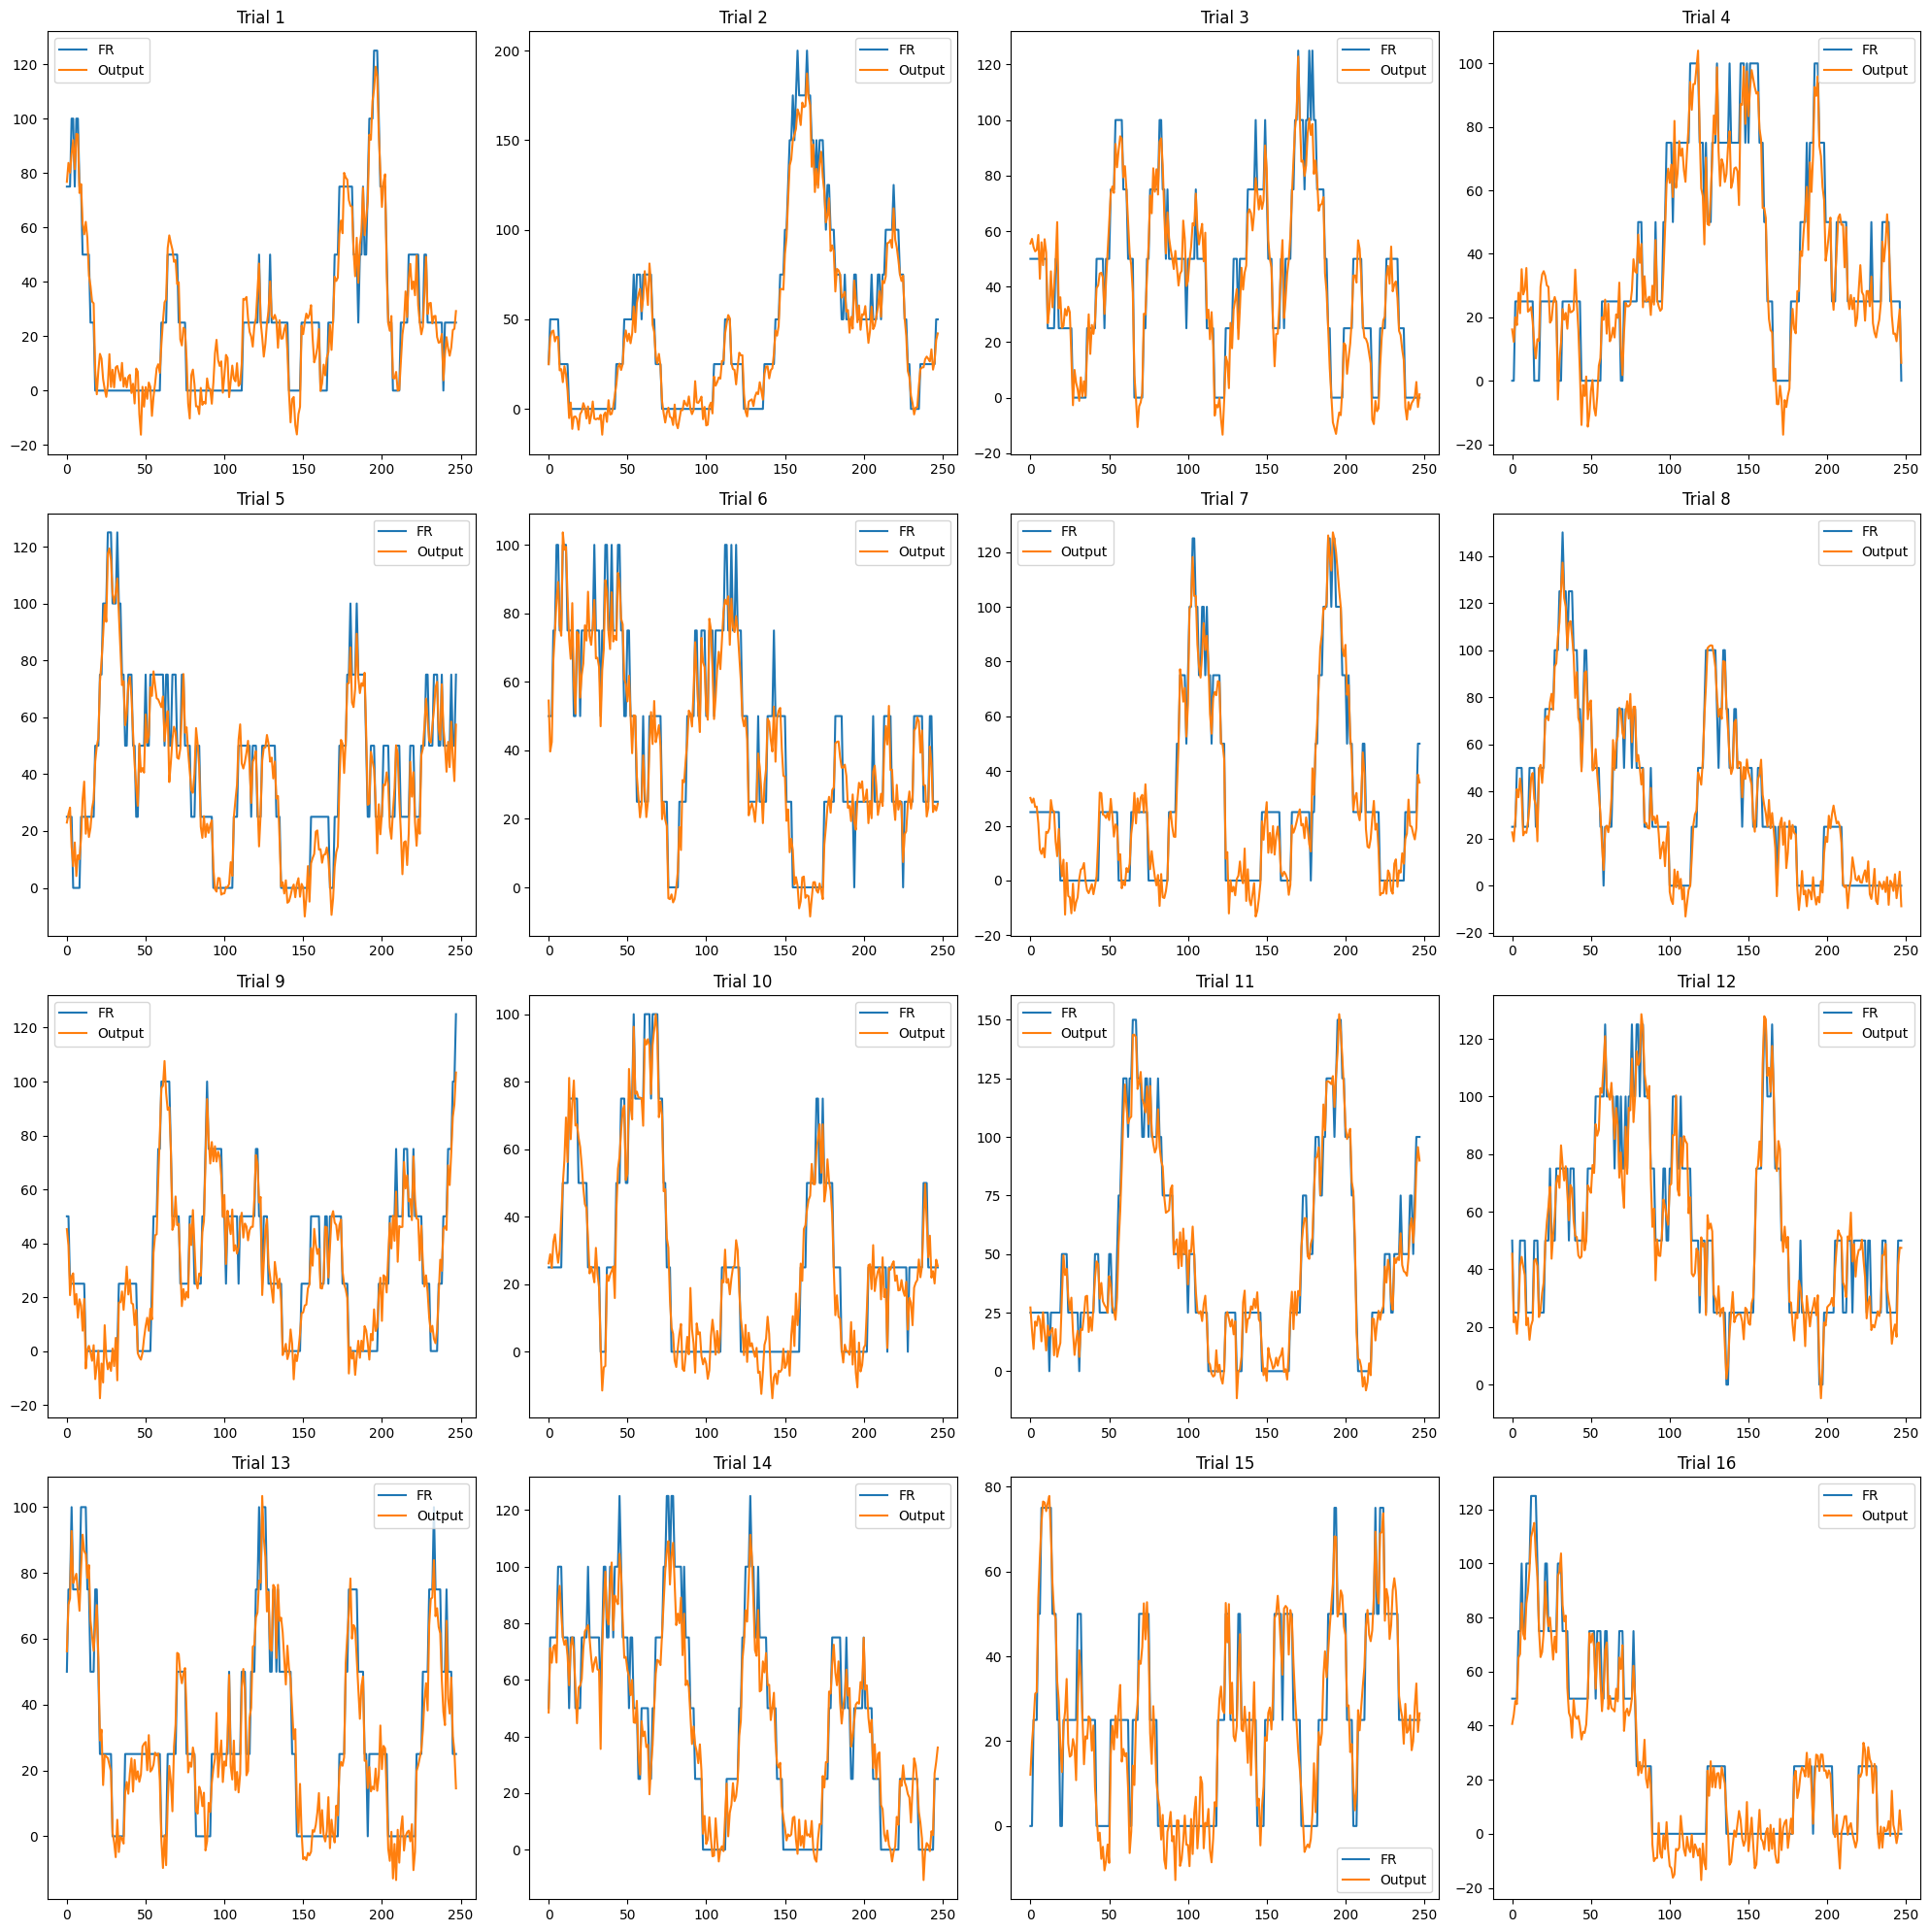

In [126]:
f, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(16):
    ax = axs[i // 4, i % 4]
    ax.plot(full_fr_data[i,:,6], label='FR')
    ax.plot(full_output[i,:,6], label='Output')
    ax.set_title(f"Trial {i+1}")
    ax.legend()
plt.tight_layout()

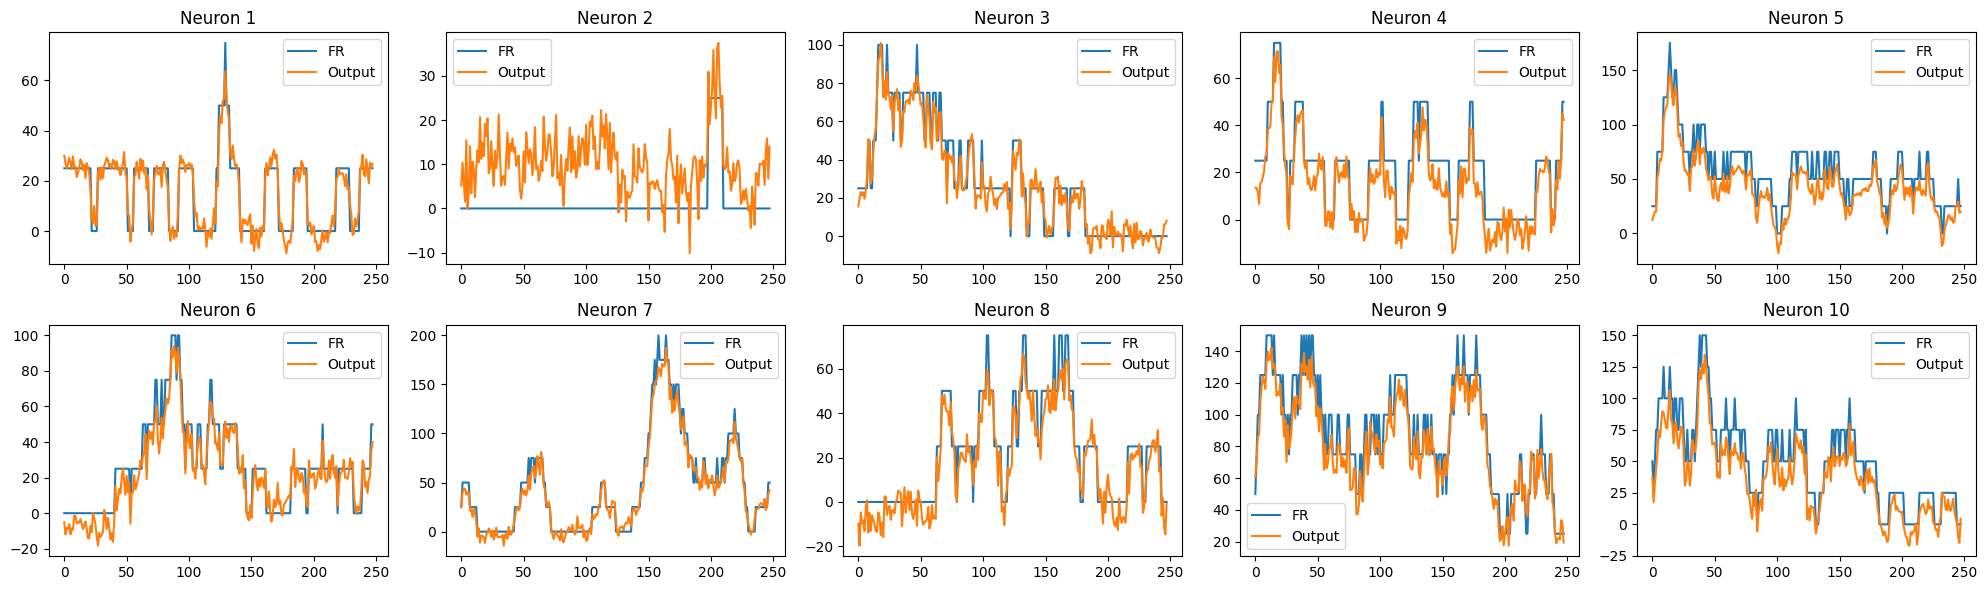

In [127]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
axs = axs.flatten()
for i in range(10):
    ax = axs[i]
    ax.plot(full_fr_data[1,:,i], label='FR')
    ax.plot(full_output[1,:,i], label='Output')
    ax.set_title(f"Neuron {i+1}")
    ax.legend()
plt.tight_layout()

In [49]:
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Number of CUDA devices: 1
Device 0: NVIDIA RTX 1000 Ada Generation Laptop GPU


In [30]:
batch_fr.shape, top_fr_inds

(torch.Size([16, 294, 73]),
 tensor([52, 68, 31, 40, 24,  7,  5, 10, 46, 43, 71, 67, 17, 36, 55, 66,  0, 61,
         38, 19, 54, 70, 57, 11, 59, 18, 16,  1, 58, 56, 34, 72, 65, 42, 50, 12,
         60, 33,  9, 37, 29,  4, 63, 14, 32, 51, 44,  6,  3, 62, 13, 45, 69,  2,
         47, 48, 64, 41, 35, 27, 49, 21, 53,  8, 39, 28, 26, 15, 23, 25, 20, 30,
         22]))

In [39]:
minibatch = torch.Tensor(batch[:20,:8])

In [31]:
batch.type

<function Tensor.type>

In [34]:
minibatch.shape,mock_input.shape

(torch.Size([16, 8, 1, 120, 112]), torch.Size([20, 8, 1, 120, 112]))

In [30]:
model(mock_input)

torch.Size([20, 8, 32])
torch.Size([20, 4, 160])
torch.Size([80, 160])
torch.Size([80, 143])


tensor([[[ 1.1607, -4.1148, -5.8142,  ..., -2.8825, -7.2852,  0.6248],
         [-0.1196, -3.3755, -4.3165,  ..., -4.0424, -6.5068,  1.7833],
         [ 0.3763, -3.3713, -4.4566,  ..., -3.4416, -6.6940,  0.8056],
         [-0.0525, -3.1021, -4.8082,  ..., -3.4263, -6.5736,  0.7067]],

        [[ 0.4007, -3.8346, -4.2856,  ..., -3.3898, -6.5060, -0.0075],
         [ 0.0547, -3.2343, -3.7081,  ..., -3.7864, -7.1544,  1.2032],
         [ 0.2250, -4.0352, -4.7056,  ..., -3.5722, -6.4416,  1.2482],
         [ 0.2712, -3.7821, -4.6178,  ..., -3.0225, -6.6972,  1.0411]],

        [[ 0.0695, -3.7158, -4.3456,  ..., -3.1536, -7.0548,  0.7229],
         [-0.1887, -4.6942, -4.0068,  ..., -3.0346, -6.5708,  0.3151],
         [ 0.3041, -3.8663, -4.9255,  ..., -3.5133, -7.1872,  1.3781],
         [ 0.1439, -3.3796, -4.3790,  ..., -3.6241, -6.3123,  0.4978]],

        ...,

        [[ 1.0602, -3.2906, -4.8104,  ..., -3.2330, -6.9652,  1.6704],
         [ 0.4087, -4.1578, -4.0702,  ..., -3.5202, -6.44

In [28]:
import torch, gc
del input_data     # delete any tensors you no longer need
gc.collect()                 # force Python GC
torch.cuda.empty_cache() 

In [29]:
model.to('cuda')
input_data = batch.to('cuda')
output = model(input_data)

torch.Size([16, 64, 32])
torch.Size([16, 60, 160])
torch.Size([960, 160])
torch.Size([960, 143])


In [ ]:
loss = torch.mean((batch_fr[:, 2:-2, top_fr_inds[-10:]].to('cuda') - output[:, :, top_fr_inds[-10:]])**2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss.backward()
optimizer.step()

# Clean up



In [38]:
256*0.0034

0.8704